# Assignment-19 

## Image Generator Using DC-GAN

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    os.chdir('/content')
    if not os.path.isdir('/content/EVA-2-Group/'):
        !git clone https://github.com/sambitdash/EVA-2-Group.git
    os.chdir('/content/EVA-2-Group/Session-19')
    !pwd
    
    !git config user.email "sambitdash@gmail.com"
    !git config user.name "Sambit Kumar Dash"
    !git config user.password "your password"
    !git status

## Image Collection

A set of car images are collected from Google. Three category of cars sedan, SUV and Hatchbacks were selected with only side view with the intention of implementing a AC-GAN but due to complexity of the convergence simple DC-GAN architecture was decided. 

The images are scaled to fit $64\times64$. 

In [2]:
import cv2
import os
import numpy as np
from os import listdir
from os.path import join

car_types = ['hatch', 'sedan', 'suv']

def resize_image(img, size=(64,64)):

    h, w = img.shape[:2]

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        c = img.shape[2]
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

spath, dpath = join('data', 'cars'), join('data', 'norm')

if not os.path.isdir(dpath):
    os.mkdir(dpath)

imgs = {}


for ct in car_types:
    sp, dp = join(spath, ct), join(dpath, ct)
    alen = 1024
    imgs[ct] = np.zeros((1024, 64, 64, 3))
    if not os.path.isdir(dp):
        os.mkdir(dp)
    tlen = 0
    for f in listdir(sp):
        sf, df = join(sp, f), join(dp, f)
        img = cv2.imread(sf)
        img = resize_image(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tlen += 1
        if tlen > alen:
            imgs[ct] = np.append(imgs[ct], np.zeros((1024, 64, 64, 3)))
            alen += 1024
        imgs[ct][tlen-1] = img
    imgs[ct] = imgs[ct][:tlen]
    print(imgs[ct].shape)

(332, 64, 64, 3)
(410, 64, 64, 3)
(337, 64, 64, 3)


## Image Standardization

The images are standardized to have pixel ranges from [-1, 1]. This is to ensure they are not fitting to the generator convention that follows a $tanh$ activation.

In [3]:
#%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

from tensorflow.keras import utils 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainx, testx = imgs['hatch'][:300,:,:,:], imgs['hatch'][300:,:,:,:]

trainy, testy = np.zeros(trainx.shape[0], dtype=float), np.zeros(testx.shape[0], dtype=float)

trainx = np.append(trainx, imgs['sedan'][:375,:,:,:], axis=0)
testx = np.append(testx, imgs['sedan'][375:,:,:,:], axis=0)

ltrain, ltest = trainx.shape[0] - trainy.shape[0], testx.shape[0] - testy.shape[0]

trainy, testy = np.append(trainy, np.ones(ltrain, dtype=float)), np.append(testy, np.ones(ltest, dtype=float))


print(trainx.shape, "y", trainy.shape)
print(testx.shape, 'y', testy.shape)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(trainx)

trainX, trainY = trainx, trainy
testX, testY   = testx, testy

for i in range(0):
    iterate = datagen.flow(trainx, trainy, batch_size=len(trainx), shuffle=True)
    x, y = iterate.next()
    trainX, trainY = np.append(trainX, x, axis=0), np.append(trainY, y, axis=0)

for i in range(0):
    iterate = datagen.flow(testx, testy, batch_size=len(testx), shuffle=True)
    x, y = iterate.next()
    testX, testY = np.append(testX, x, axis=0), np.append(testY, y, axis=0)


print(trainX.shape, "y", trainY.shape)
print(testX.shape, "y", testY.shape)

trainx, trainy = trainX, trainY
testx, testy   = testX, testY

trainx = trainx.astype('float32') / 255
testx  = testx.astype('float32') / 255

trainx_mean = np.mean(trainx, axis=(0, 1, 2))
trainx_std  = np.std(trainx, axis=(0, 1, 2))

print(trainx_mean, trainx_std)

trainx -= trainx_mean
trainx /= trainx_std

testx -= trainx_mean
testx /= trainx_std

trainX, trainY = trainx, trainy #utils.to_binary(trainy)
testX,  testY  = testx,  testy  #utils.to_binary(testy)

min_pix, max_pix = trainX.min(), trainX.max()

def align_image(x):
    min_pix, max_pix = x.min(), x.max()
    rx = x / ((max_pix-min_pix)/2.0)
    rx -= (rx.min()+1.0)
    return rx

trainX = align_image(trainX)
testX  = align_image(testX)

print(trainX.min(), trainX.max())
print(testX.min(), testX.max())

print(trainX.shape, trainY.shape)

2.0.0
(675, 64, 64, 3) y (675,)
(67, 64, 64, 3) y (67,)
(675, 64, 64, 3) y (675,)
(67, 64, 64, 3) y (67,)
[0.35301504 0.34561184 0.3417664 ] [0.37393746 0.3727019  0.37285322]
-1.0 0.99999994
-1.0 0.99999994
(675, 64, 64, 3) (675,)


## DCGAN Design

Deep convolution GAN is a simple convolution network that learns the complexities of image features and regenerates images. The GAN is composed of 2 components.

1. Discriminator
2. Generator

The discriminator is trained to distinguish between, real and fake. While the generator is trained to create such images that can pass through the discriminator's judgement. The adversial nature of training leads to creation of new patterns of images.

The code used here is a modification of code at: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

## Discriminator 

The discriminator is a simple sequential convolution network of $3x3$ kernels with LeakyReLU. LeakyReLU is suggested as it has better smoothening properties. 


In [4]:
# Code from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

# example of defining the discriminator model
import tensorflow_addons as tfa

from tensorflow_addons.layers import WeightNormalization

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

L2_REG=1e-3

def l2_weights(model):
    wts = model.get_weights()
    l2 += K.sum(wt*wt)
    return l2

def l2_loss(model, f):
    def loss(yt, yp):
        return f(yt, yp) + L2_REG*l2_weights(model)
    return loss

bce = lambda yt, yp: binary_crossentropy(yt, yp, label_smoothing=0.1)

# define the standalone discriminator model
def define_discriminator(in_shape=(64, 64, 3)):
    model = Sequential()
    # normal
    model.add(WeightNormalization(Conv2D(64, (3,3), padding='same'), input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(WeightNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same')))
    model.add(LeakyReLU(alpha=0.2))    
    # downsample
    model.add(WeightNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same')))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(WeightNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same')))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(WeightNormalization(Conv2D(256, (3,3), strides=(2,2), padding='same')))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=bce, optimizer=opt, metrics=['binary_accuracy'])
    return model
 
# define model
model = define_discriminator()
# summarize the model
#model.build(input_shape=(?,64,64,3))
model.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
weight_normalization (Weight (None, 64, 64, 64)        3649      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
weight_normalization_1 (Weig (None, 32, 32, 128)       147841    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
weight_normalization_2 (Weig (None, 16, 16, 128)       295297    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________

### Training Discriminators

Discriminators are standalone networks and can be independently trained as well with real and fake images. Fake images in this context can be natural random images. However, such training must be minimal to just oovercome initial bias towards setting all values to zeros. But discriminant must be trained with the generator and should not be over trained. If it's then generator will find it harder to generate images to bypass discriminator.

In [5]:
from numpy.random import rand, randint
from numpy import zeros, ones

def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], (n_samples,))
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y


# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    X = rand(64 * 64 * 3 * n_samples)
    X = -1 + X * 2
    X = X.reshape((n_samples, 64, 64, 3))
    y = zeros((n_samples, 1))
    return X, y

# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        real_res = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        fake_res = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%3d  real=%5.0f%% fake=%5.0f%%' % (i+1, real_res[1]*100, fake_res[1]*100))
        
train_discriminator(model, trainX) 

>  1  real=   31% fake=    6%
>  2  real=   98% fake=   86%
>  3  real=   91% fake=  100%
>  4  real=   95% fake=  100%
>  5  real=   94% fake=   97%
>  6  real=   98% fake=   97%
>  7  real=   97% fake=   97%
>  8  real=   98% fake=   92%
>  9  real=   98% fake=   98%
> 10  real=  100% fake=  100%
> 11  real=   98% fake=   98%
> 12  real=  100% fake=   94%
> 13  real=   98% fake=  100%
> 14  real=  100% fake=   97%
> 15  real=   98% fake=   98%
> 16  real=  100% fake=   98%
> 17  real=  100% fake=   98%
> 18  real=  100% fake=   98%
> 19  real=   97% fake=   95%
> 20  real=  100% fake=   97%


## Generator

Generator takes a latent dimension vector and applies the inverse operation of transposed convolution and LeakyReLU to arrive at the images. Normally a larger kernel is used for convolutions. Here (4,4) is used though several texts have suggested 5x5. 

In [6]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(WeightNormalization(Conv2DTranspose(256, (4, 4), strides=2, padding='same')))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(WeightNormalization(Conv2DTranspose(256, (4, 4), strides=2, padding='same')))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(WeightNormalization(Conv2DTranspose(256, (4, 4), strides=2, padding='same')))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(WeightNormalization(Conv2DTranspose(256, (4, 4), strides=2, padding='same')))
    model.add(LeakyReLU(alpha=0.2))    
    # output layer
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model
 
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
weight_normalization_5 (Weig (None, 8, 8, 256)         2097921   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
weight_normalization_6 (Weig (None, 16, 16, 256)       2097921   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 256)      

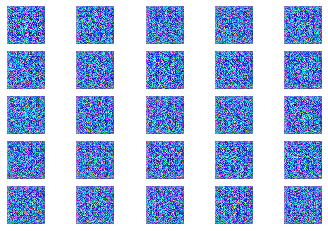

In [7]:
from numpy.random import randn
from matplotlib import pyplot
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
    # define subplot
    pyplot.subplot(5, 5, 1 + i)
    # turn off axis labels
    pyplot.axis('off')
    # plot single image
    pyplot.imshow(X[i])
# show the figure
pyplot.show()

### Training Generators

Generator is trained as a dependent network of a discriminator. The GAN training network takes the latent vector as input and generates images through generator. The output of the generator is fed into the discriminator and generator is trained with the image be passed through the discriminator as a valid input. Since, the discriminator component is marked untrainable, the generator trains itself on generating better images that can pass through the discriminator.

The `binary_crossentropy` loss is used. However, the L2-regularization is added to overcome mode collapse. The size of the latent vector also drives setting up the number of modes in the network.

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=bce, optimizer=opt, metrics=['binary_accuracy'])
    return model

In [9]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 64, 64, 3)         8812295   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1336774   
Total params: 10,149,069
Trainable params: 4,616,963
Non-trainable params: 5,532,106
_________________________________________________________________


In [10]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

## Training of GAN

The training is not carried out with standard epoch based method but carried out in single batches of alternate discriminator and generator. To be noted here, there is a potential of the network getting overfitted to one side and rejecting all fakes and thus make the training of the network extremely hard. To avoid this we introduce 5% errors in the data itself. Moreover label smoothing is carried out in the binary entropy calculation to avoid strong biases towards zeros or ones. 

The images are generated in every 200 iterations and saved for comparison. 

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_epo):   
            X_real, y_real = generate_real_samples(dataset, half_batch)
            y_real[randint(0, half_batch, (3,))] = 0.0
            d_res1 = d_model.train_on_batch(X_real, y_real)
            
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            y_fake[randint(0, half_batch, (3,))] = 1.0
            d_res2 = d_model.train_on_batch(X_fake, y_fake)
                
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            y_gan[randint(0, n_batch, (6,))] = 0
            g_res = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%10.4e, d2=%10.4e g=%10.4e' %
                  (i+1, j+1, bat_per_epo, d_res1[0], d_res2[0], g_res[0]))
        if i%200 == 199:
            summarize_performance(i, g_model, d_model, dataset, latent_dim, n_samples=150)

In [12]:
def save_plot(examples, epoch, n=12):
    target = 1000
    dpi=72
    margin=0.1
    size = target/((1.-2*margin)*dpi)
    fig = pyplot.figure(figsize=(size, size), dpi=dpi)
    fig.subplots_adjust(left=margin, right=1.-margin, wspace = 0.01, hspace=0.01)
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])

    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [13]:
latent_dim = 256
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = trainX
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, 10000)

>1, 1/5, d1=7.8509e-01, d2=6.9784e+00 g=2.4405e+00
>1, 2/5, d1=5.7251e-01, d2=9.8596e+00 g=2.0710e+00
>1, 3/5, d1=3.6394e-01, d2=5.2845e+00 g=5.8473e+00
>1, 4/5, d1=8.6271e-01, d2=1.5223e+00 g=7.5558e+00
>1, 5/5, d1=5.3139e-01, d2=4.1986e-01 g=4.9629e+00
>2, 1/5, d1=5.0997e-01, d2=2.8784e+00 g=1.0279e+01
>2, 2/5, d1=8.0382e-01, d2=4.0595e-01 g=4.5775e+00
>2, 3/5, d1=5.3565e-01, d2=4.6487e+00 g=1.1690e+01
>2, 4/5, d1=7.1506e-01, d2=8.4602e-01 g=7.7344e+00
>2, 5/5, d1=6.8477e-01, d2=7.5878e-01 g=6.9746e+00
>3, 1/5, d1=5.0239e-01, d2=5.1186e-01 g=3.5099e+00
>3, 2/5, d1=6.8767e-01, d2=1.7424e+00 g=1.1537e+01
>3, 3/5, d1=1.1067e+00, d2=7.8508e-01 g=6.5416e+00
>3, 4/5, d1=6.4963e-01, d2=4.8180e-01 g=3.8644e+00
>3, 5/5, d1=5.9343e-01, d2=4.7822e-01 g=4.9330e+00
>4, 1/5, d1=6.5121e-01, d2=3.7395e-01 g=2.9506e+00
>4, 2/5, d1=6.6933e-01, d2=1.3378e+00 g=1.1461e+01
>4, 3/5, d1=2.0336e+00, d2=6.2420e-01 g=3.3650e+00
>4, 4/5, d1=7.6048e-01, d2=1.2858e+00 g=6.3405e+00
>4, 5/5, d1=5.3097e-01, d2=7.03

>32, 5/5, d1=5.1624e-01, d2=3.6228e-01 g=2.1680e+00
>33, 1/5, d1=5.3709e-01, d2=4.1933e-01 g=2.2596e+00
>33, 2/5, d1=5.3409e-01, d2=4.0474e-01 g=2.2037e+00
>33, 3/5, d1=6.4902e-01, d2=5.3022e-01 g=2.3258e+00
>33, 4/5, d1=5.3388e-01, d2=4.1351e-01 g=2.4018e+00
>33, 5/5, d1=4.4399e-01, d2=4.4980e-01 g=2.3983e+00
>34, 1/5, d1=5.1611e-01, d2=3.7959e-01 g=2.3608e+00
>34, 2/5, d1=7.2152e-01, d2=4.5163e-01 g=2.2885e+00
>34, 3/5, d1=5.9217e-01, d2=4.0619e-01 g=2.4701e+00
>34, 4/5, d1=5.6002e-01, d2=4.1687e-01 g=2.2136e+00
>34, 5/5, d1=5.4749e-01, d2=4.6892e-01 g=2.7719e+00
>35, 1/5, d1=8.1057e-01, d2=5.8924e-01 g=2.4623e+00
>35, 2/5, d1=8.9054e-01, d2=5.5498e-01 g=2.7347e+00
>35, 3/5, d1=8.6592e-01, d2=3.6642e-01 g=2.5009e+00
>35, 4/5, d1=5.0801e-01, d2=1.1387e+00 g=7.1196e+00
>35, 5/5, d1=2.6189e+00, d2=3.9334e-01 g=2.5857e+00
>36, 1/5, d1=8.0271e-01, d2=8.9065e-01 g=1.7746e+00
>36, 2/5, d1=7.6192e-01, d2=6.2699e-01 g=2.7495e+00
>36, 3/5, d1=1.0427e+00, d2=7.8329e-01 g=3.6553e+00
>36, 4/5, d1

KeyboardInterrupt: 

## Results 

10000 epochs ![6400 epochs](gen_images/generated_plot_e10000.png).

The images are generally a bit blurry and looking closely will also clarify the images lacking in topological characteristics of the objects. Sometimes colors of various cars are merged to make a patterned design as well.